In [1]:
# import standard libraries
import numpy as np
from scipy.io import mmread, mmwrite
from scipy import linalg
from scipy import sparse
from numba import njit
import matplotlib.pyplot as plt
from pyscf import gto, dft
import numpy.ma as ma

# import methods for solving from other files
from adaptive_step_dmm import CAdaptiveDMM
from adaptive_GC import CAdaptive_GC_RK4
from adaptive_C import CAdaptive_C_RK4
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt

In [2]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# Functionf for generating the Huckel hamiltonian
def huckel_hamiltonian(alpha, beta, size):
    off_diagonals = beta*np.ones(size-1)
    diagonal = alpha*np.ones(size)
    H = sparse.diags([off_diagonals, diagonal, off_diagonals], [-1, 0, 1], format='coo', dtype=complex).toarray()
    H[0][size-1] = beta
    H[size-1][0] = beta
    return H

In [4]:
def gc_apply_method(H, S, num_electrons, beta, eps):
    # Invert S for calculation
    inv_S = linalg.inv(S)
    
    # Define chemical potential
    core_spec = linalg.eigvalsh(H, S)
    index = int(H.shape[0] / 2)
    mu = (core_spec[index] + core_spec[index - 1]) / 2
    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our GC method
    gc = CAdaptive_GC_RK4(ovlp=S, H=H, mu=mu, dbeta=dbeta, epsilon=eps)
    gc.propagate(beta)
    
    return gc

def c_apply_method(H, S, num_electrons, beta, eps):    
    # Define dbeta
    dbeta = beta / 10000
    
    # Run our C method
    c = CAdaptive_C_RK4(ovlp=S, H=H, num_electrons=num_electrons, dbeta=dbeta, epsilon=eps)
    c.propagate(beta)
    
    return c

In [5]:
np.random.seed(75)
alpha = np.random.random()
gamma = np.random.random()
print(alpha)
print(gamma)

# define the dimensions of the Hamiltonian and how many elements to consider before cutoff
size = 50
H = huckel_hamiltonian(alpha, gamma, size)
H_spect = linalg.eigvalsh(H)
print(H_spect)

# define a chemical potential mu (middle of eigenvalue spectrum)
num_electrons = int(0.5*H.shape[0])
index = int(H.shape[0] / 2)
mu = (H_spect[index] + H_spect[index-1])/2

0.5689402201192456
0.06596422758944243
[0.43701176 0.43805206 0.43805206 0.44115654 0.44115654 0.44627624
 0.44627624 0.45333043 0.45333043 0.46220786 0.46220786 0.47276852
 0.47276852 0.48484586 0.48484586 0.49824942 0.49824942 0.51276782
 0.51276782 0.52817209 0.52817209 0.54421929 0.54421929 0.56065636
 0.56065636 0.57722408 0.57722408 0.59366115 0.59366115 0.60970835
 0.60970835 0.62511262 0.62511262 0.63963102 0.63963102 0.65303458
 0.65303458 0.66511193 0.66511193 0.67567258 0.67567258 0.68455001
 0.68455001 0.6916042  0.6916042  0.6967239  0.6967239  0.69982838
 0.69982838 0.70086868]


In [6]:
# Fermi-Dirac - this simulates finite temperature
beta = 300
ferm_exact = linalg.funm(H, lambda _: np.exp(-beta*(_ - mu))/(1+np.exp(-beta*(_ - mu))))

In [7]:
# First do GC method
s = np.eye(H.shape[0], dtype=complex)
beta = 300

gc = gc_apply_method(H, s, num_electrons, beta, 1e-2)
print(gc.beta)

306.7628574265598


In [8]:
# Now do C method
c = c_apply_method(H, s, num_electrons, beta, 1e-2)
print(c.beta)

306.7628574265597


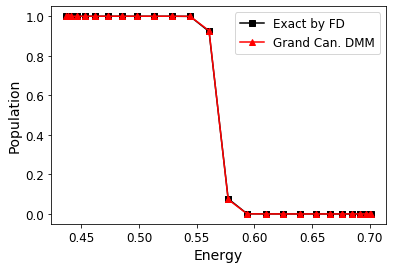

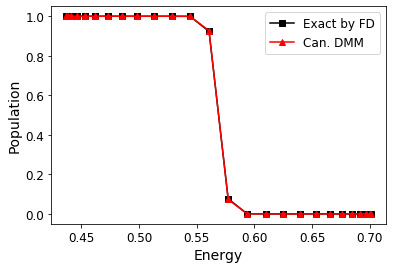

In [9]:
plt.figure(1)
plt.plot(H_spect, linalg.eigvalsh(ferm_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(H_spect, linalg.eigvalsh(gc.rho)[::-1], 'r^-', label="Grand Can. DMM")
plt.ylabel("Population")
plt.xlabel("Energy")
plt.legend(numpoints=1)
plt.savefig("adaptive_gc_huck_eigs.png", format='png', dpi=300)

plt.figure(2)
plt.plot(H_spect, linalg.eigvalsh(ferm_exact)[::-1], 'ks-', label="Exact by FD")
plt.plot(H_spect, linalg.eigvalsh(c.rho)[::-1], 'r^-', label="Can. DMM")
plt.ylabel("Population")
plt.xlabel("Energy")
plt.legend(numpoints=1)
plt.savefig("adaptive_c_huck_eigs.png", format='png', dpi=300)

In [10]:
print("GC steps: ", len(gc.mu_list))
print("C steps: ", len(c.mu_list))

GC steps:  177
C steps:  177
